In [1]:
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('dark_background')

from geopandas import read_file, GeoSeries
from shapely import Polygon

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

from statsmodels.api import qqplot

from pygam import GAM, LinearGAM, GammaGAM
from pygam import f, s, te

from xgboost import XGBRegressor

## Data Prep

In [2]:
df = pd.read_pickle('data/01_df.pkl')
df = df.drop(['region', 'state'], axis=1)
df = df.replace({'missing': pd.NA})

# Drop NA in modelled columns
df = df.dropna(subset=['condition', 'title_status'])

print(f'df.shape ---> {df.shape}')
df.head()

df.shape ---> (191340, 16)


,price,condition,cylinders,drive,fuel,lat,long,manufacturer,model,odometer,paint_color,posting_date,title_status,transmission,type,year
27,33590,good,8 cylinders,<NA>,gas,32.590,-85.4800,gmc,GMC Sierra,57923.0,white,2021-05-04,clean,other,pickup,2014.0
28,22590,good,8 cylinders,<NA>,gas,32.590,-85.4800,chevrolet,Chevrolet Silverado,71229.0,blue,2021-05-04,clean,other,pickup,2010.0
29,39590,good,8 cylinders,<NA>,gas,32.590,-85.4800,chevrolet,Chevrolet Silverado,19160.0,red,2021-05-04,clean,other,pickup,2020.0
30,30990,good,8 cylinders,<NA>,gas,32.590,-85.4800,toyota,Toyota Tundra,41124.0,red,2021-05-04,clean,other,pickup,2017.0
31,15000,excellent,6 cylinders,rwd,gas,32.592,-85.5189,ford,Ford F-150,128000.0,black,2021-05-03,clean,automatic,truck,2013.0


In [3]:
# Remove cars less than $1k
df = df[df['price'] >= 1000]
df.shape

(179071, 16)

In [4]:
# To only support 50 most common models
#most_common_models_50 = df['model'].value_counts().iloc[:50].index
#df = df[df['model'].isin(most_common_models_50)]
#print(f'df.shape ---> {df.shape}')

In [4]:
# Convert mileage to 10k miles (more interpretable coeff)
df = df.rename(columns={'odometer': 'miles_10k'})
df['miles_10k'] /= 10000
df = df[df['miles_10k'] <= 40] # Removes about 80 observations
df['miles_10k'].head()

27     5.7923
28     7.1229
29     1.9160
30     4.1124
31    12.8000
Name: miles_10k, dtype: float64

In [5]:
# Get approximate age of car in years
df['year'] = pd.to_datetime(df['year'], format='%Y')
df['car_age_years'] = (df['posting_date'] - df['year'])
df['car_age_years'] = df['car_age_years'].clip(pd.Timedelta('0 days'))
df['car_age_years'] /= pd.Timedelta('365 days')
df = df.drop(['posting_date', 'year'], axis=1)

df['car_age_years'].head()

27     7.342466
28    11.345205
29     1.339726
30     4.339726
31     8.339726
Name: car_age_years, dtype: float64

In [6]:
def get_manufacturer(s: str) -> str:

    if 'Mazda' in s:
        return 'Mazda'
    elif 'Alfa Romeo' in s:
        return 'Alfa-Romeo'
    elif 'Range Rover' in s:
        return 'Land Rover'
    else:
        r = s.split()[0]
        return r if r != 'Mercur' else 'Mercury'

df['manufacturer'] = df['model'].map(get_manufacturer)
df['manufacturer'].value_counts().head()

Ford         30556
Chevrolet    24671
Toyota       17848
Honda        11390
Jeep         10224
Name: manufacturer, dtype: int64

In [7]:
def get_model(s: str) -> str:
    if 'Mazda' in s:
        return s
    elif 'Alfa Romeo' in s:
        return 'Stevio'
    elif 'Range Rover' in s:
        return 'Range Rover Sport'
    else: return ' '.join(s.split()[1:])

# Note no model name exists with 2 manufacturers
df['model'] = df['model'].map(get_model)
df['model'].value_counts().head()

Silverado    8607
F-150        7245
1500         4666
Wrangler     4511
Sierra       4316
Name: model, dtype: int64

In [8]:
# For each model, get most common type
# and change all other types to that type
for model in df['model'].unique():
    most_common_type = df[df['model']==model]['type'].value_counts().index[0]
    df.loc[df['model']==model, 'type'] = most_common_type


print(
    'number of model-type unique pairs: '
    f'{df[["model", "type"]].value_counts().shape[0]}'
)

number of model-type unique pairs: 200


In [9]:
# Drop single observation with 12 cylinders
df = df[df['cylinders'] != '12 cylinders']

# Drop <50 observations with 'parts only' title
df = df[df['title_status'] != 'parts only']

# Change na to 'nan'
df = df.fillna('nan')

In [10]:
print(f'df.shape ---> {df.shape}')
df.head()

df.shape ---> (178947, 15)


,price,condition,cylinders,drive,fuel,lat,long,manufacturer,model,miles_10k,paint_color,title_status,transmission,type,car_age_years
27,33590,good,8 cylinders,nan,gas,32.590,-85.4800,GMC,Sierra,5.7923,white,clean,other,pickup,7.342466
28,22590,good,8 cylinders,nan,gas,32.590,-85.4800,Chevrolet,Silverado,7.1229,blue,clean,other,pickup,11.345205
29,39590,good,8 cylinders,nan,gas,32.590,-85.4800,Chevrolet,Silverado,1.9160,red,clean,other,pickup,1.339726
30,30990,good,8 cylinders,nan,gas,32.590,-85.4800,Toyota,Tundra,4.1124,red,clean,other,pickup,4.339726
31,15000,excellent,6 cylinders,rwd,gas,32.592,-85.5189,Ford,F-150,12.8000,black,clean,automatic,pickup,8.339726


In [11]:
df['cylinders'].value_counts()

nan             50322
6 cylinders     50318
4 cylinders     40023
8 cylinders     36622
5 cylinders       807
10 cylinders      523
other             187
3 cylinders       145
Name: cylinders, dtype: int64

In [12]:
factor_vars = [
    'condition', 
    'title_status', 
    'fuel', 
    'type',
    'model',
    'manufacturer',
    'cylinders', 
    'drive', 
    'transmission', 
    'paint_color'
]

# Change column order
df = df[['price', 'miles_10k', 'car_age_years']+factor_vars+['long', 'lat']]

In [13]:
# Encode categorical variables
label_encoders = {}
for var in factor_vars:
    le = LabelEncoder().fit(df[var])
    df[var] = le.transform(df[var])
    label_encoders[var] = le

df.head()

,price,miles_10k,car_age_years,condition,title_status,fuel,type,model,manufacturer,cylinders,drive,transmission,paint_color,long,lat
27,33590,5.7923,7.342466,2,0,2,6,155,10,5,2,2,11,-85.4800,32.590
28,22590,7.1229,11.345205,2,0,2,6,156,6,5,2,2,1,-85.4800,32.590
29,39590,1.9160,1.339726,2,0,2,6,156,6,5,2,2,9,-85.4800,32.590
30,30990,4.1124,4.339726,2,0,2,6,181,31,5,2,2,9,-85.4800,32.590
31,15000,12.8000,8.339726,0,0,2,6,67,9,4,3,0,0,-85.5189,32.592


In [14]:
train, test = train_test_split(df, test_size=0.20, random_state=0)

X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)

y_train = train['price']
y_test = test['price']

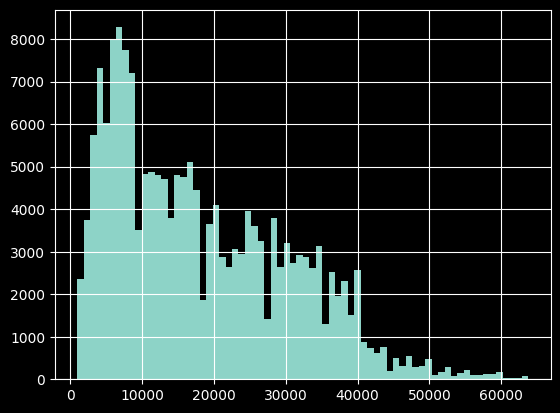

In [28]:
df['price'].hist(bins=70)
plt.show()

## Spatial Data

Unfortunetely, spatial interpolation is not scaleable to the number of observations in our dataset, and taking a subset of the data doesn't work well. Therefore, I used k-means clustering to create 100 geographic zones.

In [15]:
usa_gdf = read_file('data/us_data/cb_2018_us_nation_20m.shp')
usa_mp = usa_gdf['geometry'].values[0]

usa_bounds = Polygon([
    (-130, 23), (-130, 50),
    (-60, 50), (-60, 23)
])

continental_usa_mp = usa_mp.intersection(usa_bounds).geoms[-1]
continental_usa_gdf = GeoSeries(continental_usa_mp)

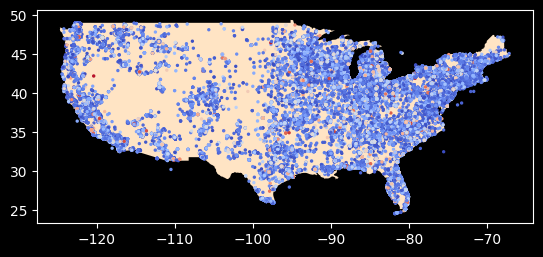

In [16]:
scatter_kwargs = {'marker': 'o', 's': 2, 'cmap': 'coolwarm'}

ax = plt.gca()
continental_usa_gdf.plot(ax=ax, color='bisque')
ax.scatter(
    df['long'], 
    df['lat'],
    c=df['price'], 
    **scatter_kwargs
)
plt.show()

In [17]:
k_means_coords = KMeans(n_clusters=100, random_state=11, n_init='auto')

df_cluster_train = pd.DataFrame({
    'long': train['long'], 
    'lat': train['lat'],
    'cluster': k_means_coords.fit_predict(X_train[['long', 'lat']])
})

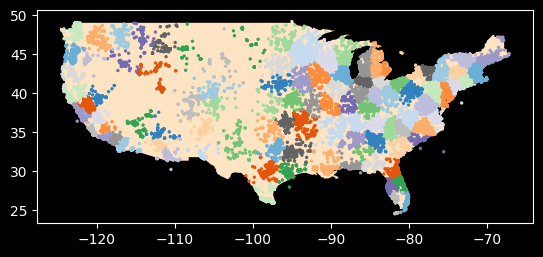

In [18]:
ax = plt.gca()
continental_usa_gdf.plot(ax=ax, color='bisque')
ax.scatter(
    df_cluster_train['long'],
    df_cluster_train['lat'],
    c=df_cluster_train['cluster'],
    cmap='tab20c',
    s=2,
    marker='o'
)
plt.show()

In [19]:
X_train['cluster'] = df_cluster_train['cluster']
X_test['cluster'] = k_means_coords.predict(X_test[['long', 'lat']])

In [20]:
#X_train.to_csv('data_clean/X_train.csv')
#X_test.to_csv('data_clean/X_test.csv')
#y_train.to_csv('data_clean/y_train.csv')
#y_test.to_csv('data_clean/y_test.csv')

## XGBoost

In [233]:
xgb_X_train = pd.get_dummies(X_train, columns=factor_vars['all']+['cluster'])
xgb_X_test = pd.get_dummies(X_test, columns=factor_vars['all']+['cluster'])

xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    random_state=0,
    eval_metrics=mean_squared_error,
    verbosity=0
)

In [235]:
%%time
xgb_reg.fit(xgb_X_train, y_train);

CPU times: total: 34min 22s
Wall time: 5min 51s


In [236]:
xgb_reg_train_mae = mean_absolute_error(y_train, xgb_reg.predict(xgb_X_train))
xgb_reg_test_mae = mean_absolute_error(y_test, xgb_reg.predict(xgb_X_test))

print(xgb_reg_train_mae, xgb_reg_test_mae)

1444.757237615225 1737.451914135362


## GAM Utils

In [25]:
def plot_mileage_age_curves(gam: GAM):

    miles_pd = gam.partial_dependence(term=0)[:40]
    age_pd = gam.partial_dependence(term=1)[:40]

    ax = plt.gca()
    ax.set_ylabel('Effect on Price')
    ax.set_xlabel('miles_10k / car_age_years')
    ax.plot(miles_pd, label='miles_10k')
    ax.plot(age_pd, label='car_age_years')
    ax.legend()
    plt.show()

In [26]:
def gam_diagnostics_plot(gam: GAM, X_train: np.ndarray, y_train: np.ndarray):

    y_train_hat = gam.predict_mu(X_train)
    residuals = gam.deviance_residuals(X_train, y_train)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    # qq plot
    axs[0, 0].set_title('QQ')
    qqplot(residuals, ax=axs[0, 0], line='s')

    # residuals vs linear predictor
    axs[0, 1].set_title('residuals vs prediction')
    axs[0, 1].scatter(x=y_train_hat, y=residuals)
    axs[0, 1].set_xlabel('predicted value')
    axs[0, 1].set_ylabel('residual')

    # residuals histogram
    axs[1, 0].set_title('residuals histogram')
    axs[1, 0].hist(residuals, bins=75)
    axs[1, 0].set_xlabel('residual')
    axs[1, 0].set_ylabel('frequency')

    # observed vs fitted values
    axs[1, 1].set_title('observed vs fitted values')
    axs[1, 1].scatter(x=y_train, y=y_train_hat)
    axs[1, 1].set_xlabel('observed value')
    axs[1, 1].set_ylabel('fitted value')
    axs[1, 1].plot(np.arange(y_train.max()), color='red')

    plt.show()


In [27]:
def print_gam_summary_stats(gam: GAM):
    stats = gam.statistics_
    
    edof = stats['edof']
    aic = stats['AIC']
    aicc = stats['AICc']
    r2 = stats['pseudo_r2']['explained_deviance']
    gcv = stats['GCV']

    print(f'Effective degrees of freedom: {edof}')
    print(f'AIC: {aic}')
    print(f'AICc: {aicc}')
    print(f'Pseudo R^2: {r2}')
    print(f'GCV: {gcv}')


## GAM 1

All variables, no interactions, no geographic data

In [24]:
gam_1_miles_spline = s(0, n_splines=10, lam=0.6)
gam_1_age_spline = s(1, n_splines=10, lam=0.6)

gam_1_model = gam_1_miles_spline + gam_1_age_spline
for var in factor_vars:
    if var != 'cluster':
        gam_1_model += f(X_train.columns.get_loc(var))

gam_1_model

s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11)

In [25]:
# Grid search does not lead to significant improvement
t0 = time.time()
gam_1 = LinearGAM(gam_1_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam1 fit time: {t} seconds')

gam1 fit time: 17.47403073310852 seconds


In [26]:
gam_1_y_train_hat = gam_1.predict(X_train).clip(0)
gam_1_train_mae = mean_absolute_error(y_train, gam_1_y_train_hat)

gam_1_y_test_hat = gam_1.predict(X_test).clip(0)
gam_1_test_mae = mean_absolute_error(y_test, gam_1_y_test_hat)

print(f'gam1 train set mean absolute error: {gam_1_train_mae}')
print(f'gam1 test set mean absolute error: {gam_1_test_mae}')

gam1 train set mean absolute error: 3445.9941451204786
gam1 test set mean absolute error: 3464.4790673526572


In [30]:
print_gam_summary_stats(gam_1)

Effective degrees of freedom: 251.69645617610274
AIC: 5127778.236801752
AICc: 5127779.134026572
Pseudo R^2: 0.8414182071139004
GCV: 23964809.512067813


In [50]:
with open('gams/gam_1.pkl', 'wb') as f:
    pickle.dump(gam_1, f)

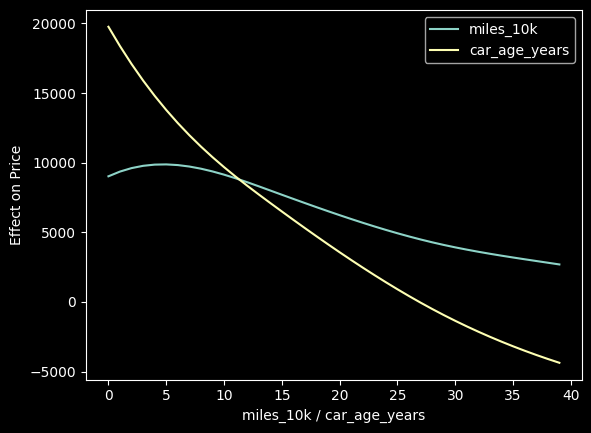

In [65]:
plot_mileage_age_curves(gam_1)

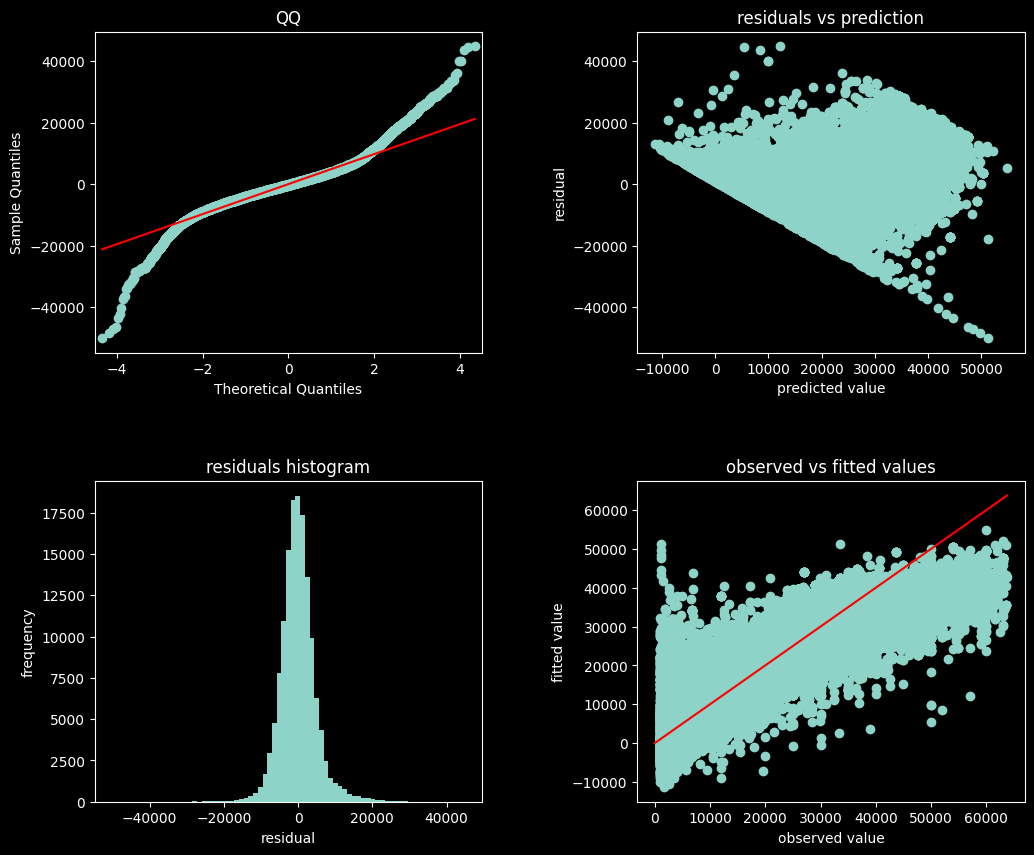

In [57]:
gam_diagnostics_plot(gam_1, X_train, y_train)

## GAM 2

All variables, interaction between mileage, age, condition and manufacturer

In [34]:
# Splines
gam_2_model = s(0, n_splines=10, lam=0.6) 
gam_2_model += s(1, n_splines=10, lam=0.6)

# Factors
for var in factor_vars:
    idx = X_train.columns.get_loc(var)
    gam_2_model += f(idx)

# Interactions
gam_2_model += te(s(0, n_splines=10, lam=0.6), f(7)) # miles*manufacturer
gam_2_model += te(s(1, n_splines=10, lam=0.6), f(7)) # age*manufacturer
gam_2_model += te(f(2), f(7))                        # condition*manufacturer

gam_2_model

s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + te(0, 7) + te(1, 7) + te(2, 7)

In [35]:
t0 = time.time()
gam_2 = LinearGAM(gam_2_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam2 training time: {t} seconds')

gam2 training time: 121.26159834861755 seconds


In [36]:
gam_2_y_train_hat = gam_2.predict(X_train).clip(0)
gam_2_train_mae = mean_absolute_error(y_train, gam_2_y_train_hat)

gam_2_y_test_hat = gam_2.predict(X_test).clip(0)
gam_2_test_mae = mean_absolute_error(y_test, gam_2_y_test_hat)

print(f'gam2 train set mean absolute error: {gam_2_train_mae}')
print(f'gam2 test set mean absolute error: {gam_2_test_mae}')

gam2 train set mean absolute error: 3108.8755928673413
gam2 test set mean absolute error: 3128.0223758836178


In [37]:
print_gam_summary_stats(gam_2)

Effective degrees of freedom: 655.1339654843607
AIC: 5082902.186229737
AICc: 5082908.2377149295
Pseudo R^2: 0.8651870767255034
GCV: 20534984.89679673


In [49]:
with open('gams/gam_2.pkl', 'wb') as f:
    pickle.dump(gam_2, f)

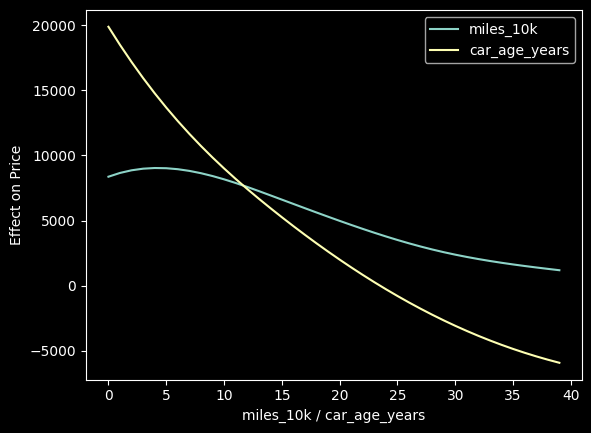

In [30]:
plot_mileage_age_curves(gam_2)

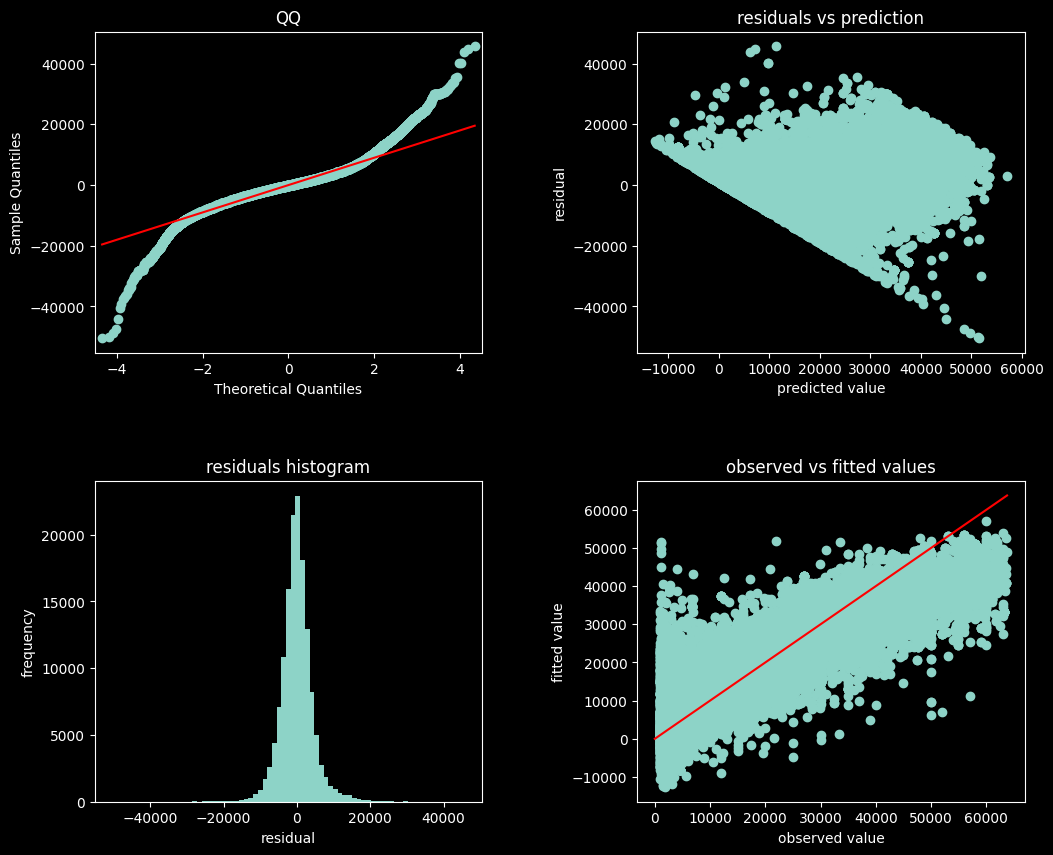

In [38]:
gam_diagnostics_plot(gam_2, X_train, y_train)

## GAM 3
All variables, interactions between mileage, age, condition and manufacturer, geographic zones

In [53]:
# Splines
gam_3_model = s(0, n_splines=10, lam=0.6) 
gam_3_model += s(1, n_splines=10, lam=0.6)

# Factors
for var in factor_vars + ['cluster']:
    idx = X_train.columns.get_loc(var)
    gam_3_model += f(idx)

# Interactions
gam_3_model += te(s(0, n_splines=10), f(7)) #miles*manufacturer
gam_3_model += te(s(1, n_splines=10), f(7)) #age*manufacturer
gam_3_model += te(f(4), f(7)) #condition*manufacturer

gam_3_model

s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(14) + te(0, 7) + te(1, 7) + te(4, 7)

In [54]:
t0 = time.time()
gam_3 = LinearGAM(gam_3_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam3 training time: {t} seconds')

gam3 training time: 139.27465653419495 seconds


In [57]:
gam_3_y_train_hat = gam_3.predict(X_train).clip(0)
gam_3_train_mae = mean_absolute_error(y_train, gam_3_y_train_hat)

gam_3_y_test_hat = gam_3.predict(X_test).clip(0)
gam_3_test_mae = mean_absolute_error(y_test, gam_3_y_test_hat)

print(f'gam3 train set mean absolute error: {gam_3_train_mae}')
print(f'gam3 test set mean absolute error: {gam_3_test_mae}')

gam3 train set mean absolute error: 3041.5618667579483
gam3 test set mean absolute error: 3058.7119992635257


In [58]:
print_gam_summary_stats(gam_3)

Effective degrees of freedom: 710.2149413568507
AIC: 5071869.914259342
AICc: 5071877.026319043
Pseudo R^2: 0.8703829119075429
GCV: 19764969.279676165


In [48]:
with open('gams/gam_3.pkl', 'wb') as f:
    pickle.dump(gam_3, f)

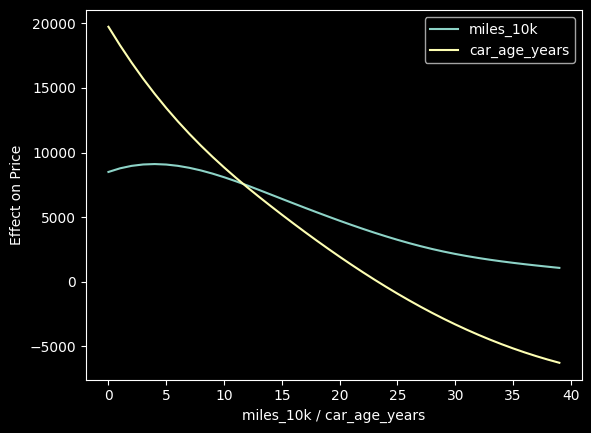

In [66]:
plot_mileage_age_curves(gam_3)

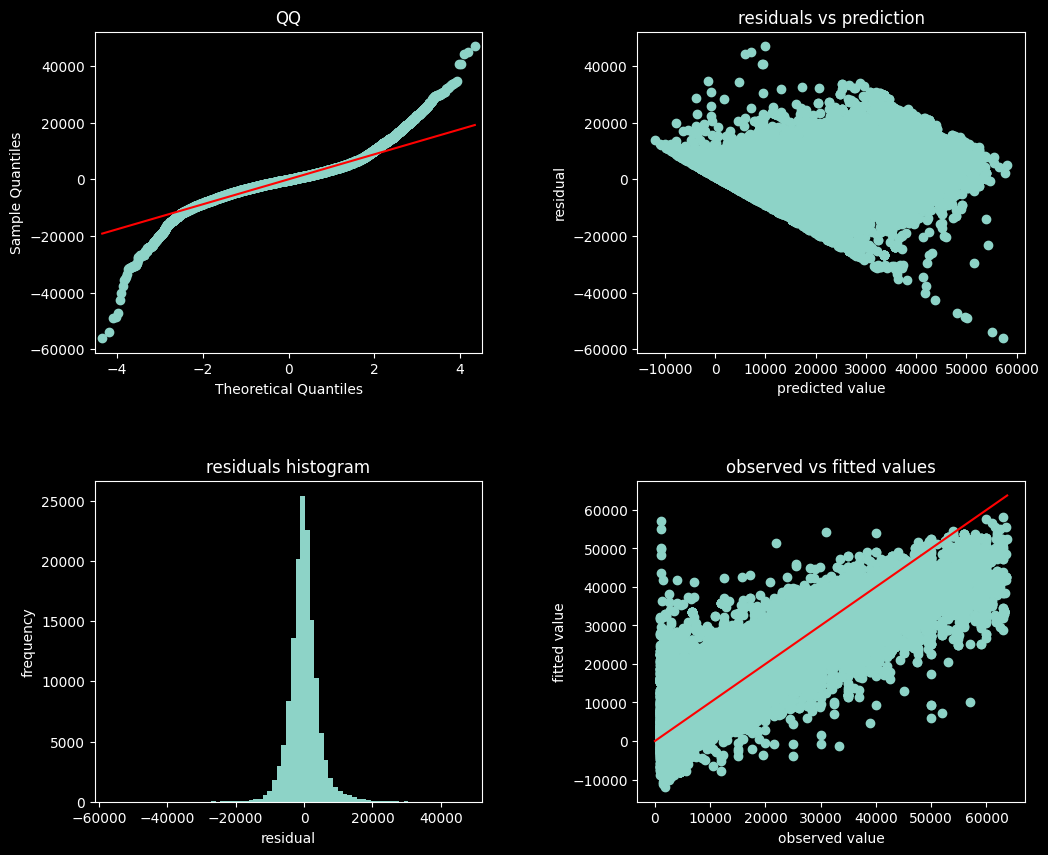

In [45]:
gam_diagnostics_plot(gam_3, X_train, y_train)

## GAM 4 (best model)
All variables, interactions between mileage, age, condition, and manufacturer, geographic zones, Gamma Regression (necessarily positve predictions)

In [21]:
# Splines
gam_4_model = s(0, n_splines=10, lam=0.6) 
gam_4_model += s(1, n_splines=10, lam=0.6)

# Factors
for var in factor_vars + ['cluster']:
    idx = X_train.columns.get_loc(var)
    gam_4_model += f(idx)

# Interactions
gam_4_model += te(s(0, n_splines=10), f(7)) #miles*manufacturer
gam_4_model += te(s(1, n_splines=10), f(7)) #age*manufacturer
gam_4_model += te(f(2), f(7)) #condition*manufacturer

gam_4_model

s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(14) + te(0, 7) + te(1, 7) + te(2, 7)

In [44]:
t0 = time.time()
gam_4 = GammaGAM(gam_4_model).fit(X_train, y_train)
t = time.time() - t0
print(f'gam4 training time: {t} seconds')

with open('gams/gam_4.pkl', 'wb') as f_gam:
    pickle.dump(gam_4, f_gam)

gam4 training time: 481.7773880958557 seconds


In [22]:
with open('gams/gam_4.pkl', 'rb') as f_gam:
    gam_4 = pickle.load(f)

In [23]:
gam_4_y_train_hat = gam_4.predict_mu(X_train)
gam_4_train_mae = mean_absolute_error(y_train, gam_4_y_train_hat)

gam_4_y_test_hat = gam_4.predict_mu(X_test)
gam_4_test_mae = mean_absolute_error(y_test, gam_4_y_test_hat)

print(f'gam4 train set mean absolute error: {gam_4_train_mae}')
print(f'gam4 test set mean absolute error: {gam_4_test_mae}')

gam4 train set mean absolute error: 2879.1559496227687
gam4 test set mean absolute error: 2898.4038229258754


In [28]:
print_gam_summary_stats(gam_4)

Effective degrees of freedom: 753.9971625063325
AIC: 2768668.3185923942
AICc: 2768676.335048756
Pseudo R^2: 0.864934121120585
GCV: 0.07614130501462736


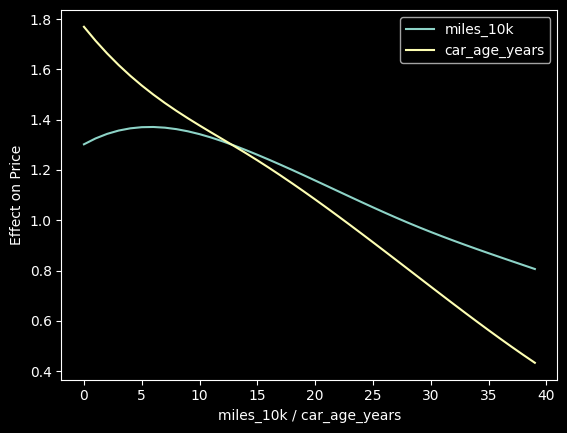

In [29]:
plot_mileage_age_curves(gam_4)

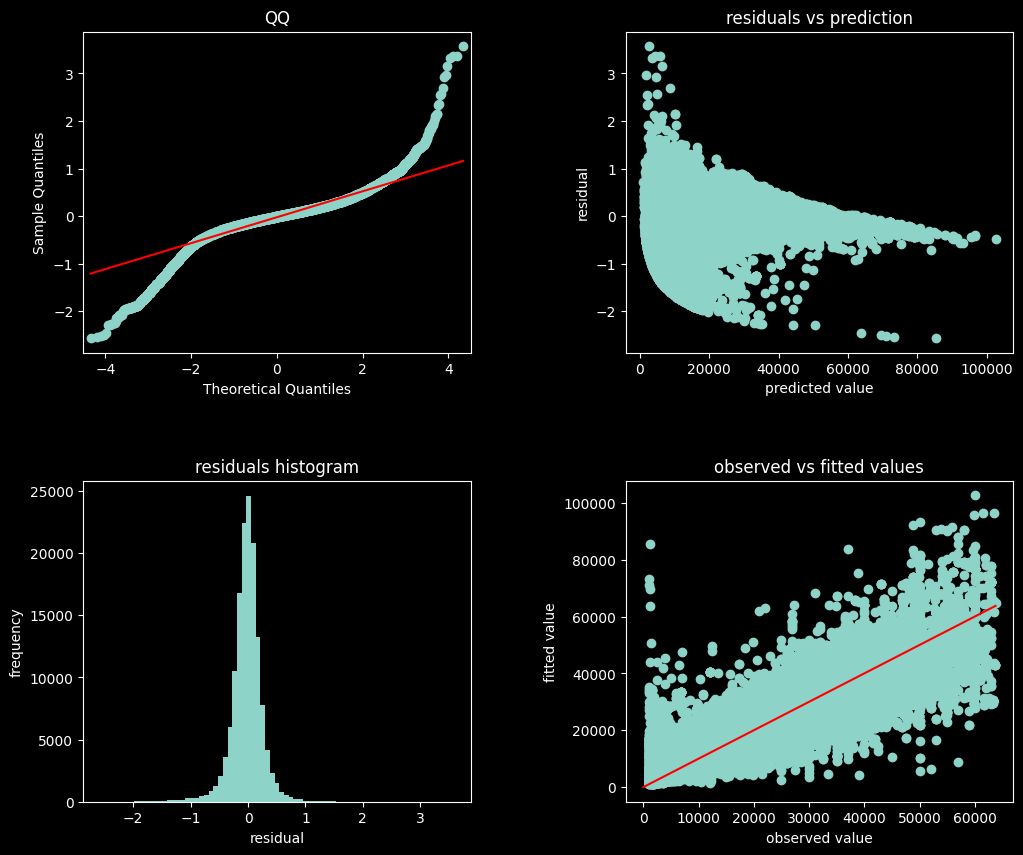

In [30]:
gam_diagnostics_plot(gam_4, X_train, y_train)